In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

!tar -xvzf "/content/drive/MyDrive/lens_data_alt.tgz";

Streaming output truncated to the last 5000 lines.
lens_data/image_129921264748304580224978784123993897887.npy
lens_data/image_60674821045913106252338146417083597669.npy
lens_data/image_7586588992730644946273072343065751609.npy
lens_data/image_256615804082514045226068245569293561600.npy
lens_data/image_331318447763555722421727000564541383144.npy
lens_data/image_306434472647715886273091851647655788036.npy
lens_data/image_153218353373199188551319913929375882134.npy
lens_data/image_11412000761836877732825972164665604473.npy
lens_data/image_266881034011026170985732508767754319849.npy
lens_data/image_322127030264560088986489885939769106814.npy
lens_data/image_103941636199723507484958618254099927151.npy
lens_data/image_182258691333363044109515573847422173318.npy
lens_data/image_317193050927123178027142767517329150638.npy
lens_data/image_7313831936673811745893506016093993651.npy
lens_data/image_123432310684084797411926937999919367992.npy
lens_data/image_234115468553431369454037687583967250944

# Importing Libaries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [68]:
# crate a dataset for regression task
class LensDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.file_list = os.listdir(path)
        self.file_list.sort()
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        data = np.load(self.path + '/' + self.file_list[idx], allow_pickle=True)
        image = data[0]
        mass = torch.tensor(data[1], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mass
        
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [124]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224,224)),
                transforms.Lambda(lambda x: x.to(torch.float32).repeat(3,1,1)),
                # transforms.Lambda(lambda x: x.to(torch.float32)),
                # transforms.RandomHorizontalFlip(p = 0.25),
                # transforms.RandomVerticalFlip(p = 0.25),

            ])

dataset = LensDataset("lens_data", transform= transform)

train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)])
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), len(train_dataset) - int(len(train_dataset) * 0.9)])

augment = transforms.Compose([   
                transforms.RandomHorizontalFlip(p = 0.25),
                transforms.RandomVerticalFlip(p = 0.25),
                ])

train_dataset = DatasetFromSubset(
    train_dataset, transform=augment)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [13]:
# Explore the dataset
print('Train dataset size: ', len(train_dataset))
print('Validation dataset size: ', len(val_dataset))
print('Test dataset size: ', len(test_dataset))

# get image shape
print('Image shape: ', train_dataset[0][0].shape)

# type of image tensor
print('Type of image tensor: ', train_dataset[0][0].dtype)

# number of batches in train loader
print('Number of batches in train loader: ', len(train_loader))

Train dataset size:  16200
Validation dataset size:  1800
Test dataset size:  2000
Image shape:  torch.Size([1, 150, 150])
Type of image tensor:  torch.float32
Number of batches in train loader:  254


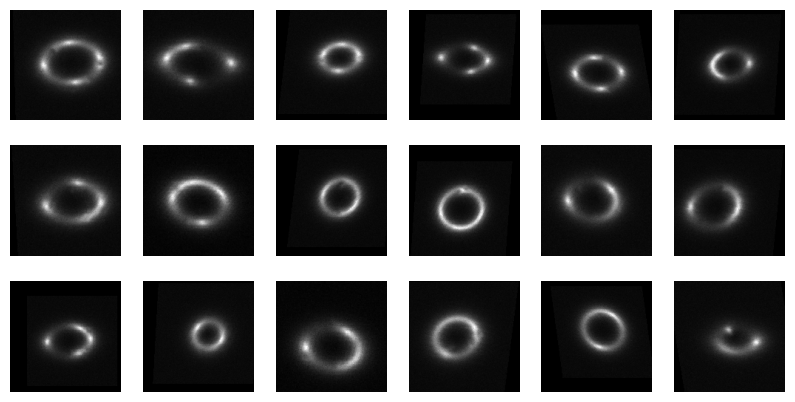

In [14]:
# plot some images
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    rand = torch.randint(0, len(train_dataset), (1,)).item()
    ax.imshow(train_dataset[rand][0].permute(1,2,0), cmap='gray')
    ax.axis('off')

# Training and Test Functions

In [84]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, n_epochs, scheduler = None):

    # train_losses = []
    min_val_loss = 1e9
    for epoch in range(1, n_epochs+1):
        # Keep track of training and validation loss
        train_loss = 0.0

        # Train the model
        model.train()
        for batch, (inputs, labels) in enumerate(tqdm(train_loader)):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs.ravel(), labels)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
        # Evaluate the model
        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
          for data in tqdm(valid_loader):
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              loss = loss_fn(outputs.ravel(), labels)
              valid_loss += loss.item()

        
        # Calculate average losses
        train_MSE = train_loss/len(train_loader)
        val_MSE = valid_loss/len(valid_loader)

        # train_losses.append(train_loss)
        # val_losses.append(valid_loss)

        scheduler.step(valid_loss)

        if val_MSE < min_val_loss:
            min_val_loss = val_MSE
            torch.save(model.state_dict(), f'/content/drive/MyDrive/MBNv3_best.pth')
            print(f"saved model at {epoch}")

        print(f'Epoch: {epoch} \tTraining Loss: {train_MSE:.6f}| Validation Loss: {val_MSE:.6f}')
    # return train_losses, val_losses

In [35]:
def test(model, test_loader, loss_fn):
    test_loss = 0.0
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
      for data in tqdm(test_loader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs.ravel(), labels)

          y_pred.extend(outputs.cpu().detach().numpy())
          y_true.extend(labels.cpu().detach().numpy())

          test_loss += loss.item()
      
    test_loss = test_loss/len(test_loader)


    # plot label vs prediction
    plt.figure(figsize=(10,10))
    plt.scatter(y_true, y_pred)
    plt.xlabel("True Mass")
    plt.ylabel("Predicted Mass")
    plt.title("True Mass vs Predicted Mass")
    plt.show()
    print(f'Test Loss: {test_loss:.6f}')
    return test_loss

# Model Initialization

# Simple Model

In [17]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        # depthwise convolution with kernel size 3 and stride 2
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, groups=1)
        # pointwise convolution to increase channels
        self.conv2 = nn.Conv2d(32, 64, 1)
        # depthwise convolution with kernel size 3 and stride 2
        self.conv3 = nn.Conv2d(64, 64, 3, stride=2, groups=64)
        # pointwise convolution to increase channels
        self.conv4 = nn.Conv2d(64, 128, 1)
        # depthwise convolution with kernel size 3 and stride 2
        self.conv5 = nn.Conv2d(128, 128, 3, stride=2, groups=128)
        # pointwise convolution to increase channels
        self.conv6 = nn.Conv2d(128, 256, 1)
        # global average pooling to reduce spatial dimensions
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # fully connected layer to output a single value
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        # input shape: (batch_size, 1, 150, 150)
        x = F.relu(self.conv1(x)) # shape: (batch_size, 32, 74, 74)
        x = F.relu(self.conv2(x)) # shape: (batch_size, 64, 74, 74)
        x = F.relu(self.conv3(x)) # shape: (batch_size, 64, 36, 36)
        x = F.relu(self.conv4(x)) # shape: (batch_size, 128, 36, 36)
        x = F.relu(self.conv5(x)) # shape: (batch_size, 128, 17, 17)
        x = F.relu(self.conv6(x)) # shape: (batch_size, 256, 17, 17)
        x = self.avgpool(x) # shape: (batch_size, 256, 1 ,1)
        x = x.view(x.size(0), -1) # shape: (batch_size ,256)
        x = self.fc(x) # shape: (batch_size ,1)
        return x
  
print(sum(p.numel() for p in SimpleModel().parameters() if p.requires_grad))

45953


# MobileNetV3

In [10]:
gc.collect()
torch.cuda.empty_cache()

In [81]:
#1x150x150
MobileNetV3 = torchvision.models.mobilenet_v3_small()

MobileNetV3.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
MobileNetV3.classifier[-1] = nn.Linear(1024, 1)

# load the model
# MobileNetV3.load_state_dict(torch.load('MobileNetV3_Reg.pth'))

MobileNetV3.to(device);


# Resnet18

In [105]:
Resnet18 = torchvision.models.resnet18(weights = True)
# modify it to accept 1x150x150 input
Resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
Resnet18.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 1))
# Resnet18.load_state_dict(torch.load("Resnet18_reg.pth"))
Resnet18 = Resnet18.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [98]:
# 3x224x224 image size
EffNet = torchvision.models.efficientnet_b5()
EffNet.classifier[-1] = nn.Sequential(nn.Linear(in_features=2048, out_features=1024, bias=True), nn.Linear(in_features=1024, out_features=1, bias=True))
EffNet.to(device);

# load if trained before
EffNet.load_state_dict(torch.load('Effnetb5.pth'))

<All keys matched successfully>

# Train and Test Functions

In [127]:
torch.save(Resnet18.state_dict(), '/content/drive/MyDrive/Resnet18_REG.pth')
torch.save(MobileNetV3.state_dict(), '/content/drive/MyDrive/MBNV3_REG.pth')
torch.save(EffNet.state_dict(), '/content/drive/MyDrive/EFF_REG.pth')

In [112]:
model = Resnet18
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, factor = 0.5)
loss_fn = nn.MSELoss()

train(model, train_loader, val_loader, loss_fn, optimizer, 30, scheduler)
torch.save(model.state_dict(), '/content/drive/MyDrive/SimpleModel.pth')

100%|██████████| 57/57 [00:01<00:00, 29.32it/s]


saved model at 1
Epoch: 1 	Training Loss: 0.000112| Validation Loss: 0.000094


100%|██████████| 57/57 [00:01<00:00, 35.25it/s]


saved model at 2
Epoch: 2 	Training Loss: 0.000095| Validation Loss: 0.000081


100%|██████████| 57/57 [00:01<00:00, 35.56it/s]


Epoch: 3 	Training Loss: 0.000088| Validation Loss: 0.000094


100%|██████████| 57/57 [00:01<00:00, 28.96it/s]


Epoch: 4 	Training Loss: 0.000085| Validation Loss: 0.000255


100%|██████████| 57/57 [00:01<00:00, 35.58it/s]


Epoch: 5 	Training Loss: 0.000080| Validation Loss: 0.000115


100%|██████████| 57/57 [00:01<00:00, 35.49it/s]


Epoch: 6 	Training Loss: 0.000084| Validation Loss: 0.000093


100%|██████████| 57/57 [00:01<00:00, 35.46it/s]


Epoch: 7 	Training Loss: 0.000072| Validation Loss: 0.000081


100%|██████████| 57/57 [00:01<00:00, 29.31it/s]


Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 8 	Training Loss: 0.000074| Validation Loss: 0.000081


100%|██████████| 57/57 [00:01<00:00, 32.10it/s]


saved model at 9
Epoch: 9 	Training Loss: 0.000053| Validation Loss: 0.000072


100%|██████████| 57/57 [00:01<00:00, 35.45it/s]


Epoch: 10 	Training Loss: 0.000049| Validation Loss: 0.000163


100%|██████████| 57/57 [00:01<00:00, 35.09it/s]


Epoch: 11 	Training Loss: 0.000052| Validation Loss: 0.000085


100%|██████████| 57/57 [00:01<00:00, 31.14it/s]


Epoch: 12 	Training Loss: 0.000043| Validation Loss: 0.000073


100%|██████████| 57/57 [00:01<00:00, 32.88it/s]


Epoch: 13 	Training Loss: 0.000042| Validation Loss: 0.000129


100%|██████████| 57/57 [00:01<00:00, 36.20it/s]


Epoch: 14 	Training Loss: 0.000041| Validation Loss: 0.000076


100%|██████████| 57/57 [00:01<00:00, 35.63it/s]


Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.
Epoch: 15 	Training Loss: 0.000039| Validation Loss: 0.000116


100%|██████████| 57/57 [00:01<00:00, 31.44it/s]


Epoch: 16 	Training Loss: 0.000029| Validation Loss: 0.000094


100%|██████████| 57/57 [00:01<00:00, 34.33it/s]


Epoch: 17 	Training Loss: 0.000030| Validation Loss: 0.000079


100%|██████████| 57/57 [00:01<00:00, 35.97it/s]


Epoch: 18 	Training Loss: 0.000029| Validation Loss: 0.000085


100%|██████████| 57/57 [00:01<00:00, 35.16it/s]


Epoch: 19 	Training Loss: 0.000030| Validation Loss: 0.000075


100%|██████████| 57/57 [00:01<00:00, 31.96it/s]


saved model at 20
Epoch: 20 	Training Loss: 0.000025| Validation Loss: 0.000070


100%|██████████| 57/57 [00:01<00:00, 35.74it/s]


Epoch: 21 	Training Loss: 0.000026| Validation Loss: 0.000079


100%|██████████| 57/57 [00:01<00:00, 35.40it/s]


Epoch: 22 	Training Loss: 0.000025| Validation Loss: 0.000073


100%|██████████| 57/57 [00:01<00:00, 35.61it/s]


Epoch: 23 	Training Loss: 0.000024| Validation Loss: 0.000095


100%|██████████| 57/57 [00:01<00:00, 36.04it/s]


Epoch: 24 	Training Loss: 0.000022| Validation Loss: 0.000102


100%|██████████| 57/57 [00:01<00:00, 29.53it/s]


Epoch: 25 	Training Loss: 0.000021| Validation Loss: 0.000071


100%|██████████| 57/57 [00:01<00:00, 35.69it/s]


Epoch 00026: reducing learning rate of group 0 to 1.2500e-05.
Epoch: 26 	Training Loss: 0.000021| Validation Loss: 0.000071


100%|██████████| 57/57 [00:01<00:00, 35.64it/s]


Epoch: 27 	Training Loss: 0.000017| Validation Loss: 0.000079


100%|██████████| 57/57 [00:01<00:00, 34.50it/s]


Epoch: 28 	Training Loss: 0.000017| Validation Loss: 0.000070


100%|██████████| 57/57 [00:01<00:00, 30.64it/s]


Epoch: 29 	Training Loss: 0.000016| Validation Loss: 0.000083


100%|██████████| 57/57 [00:01<00:00, 35.80it/s]

Epoch: 30 	Training Loss: 0.000015| Validation Loss: 0.000072


# Test

100%|██████████| 63/63 [00:02<00:00, 28.75it/s]


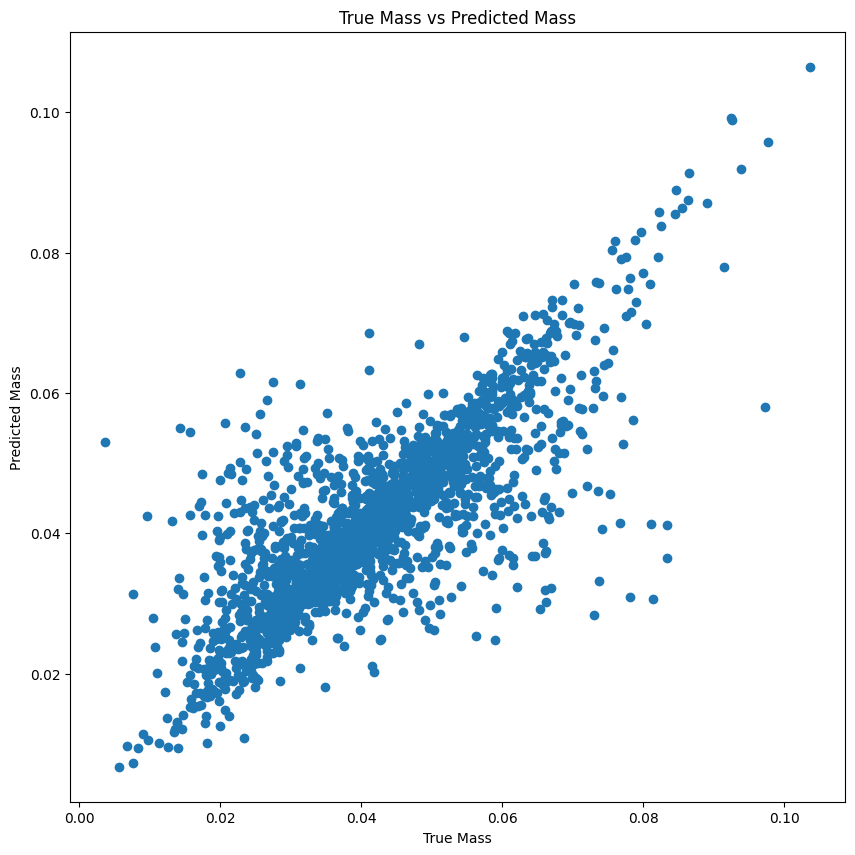

Test Loss: 0.000081


8.089121469570923e-05

In [122]:
test(MobileNetV3, test_loader, nn.MSELoss())

100%|██████████| 63/63 [00:02<00:00, 30.89it/s]


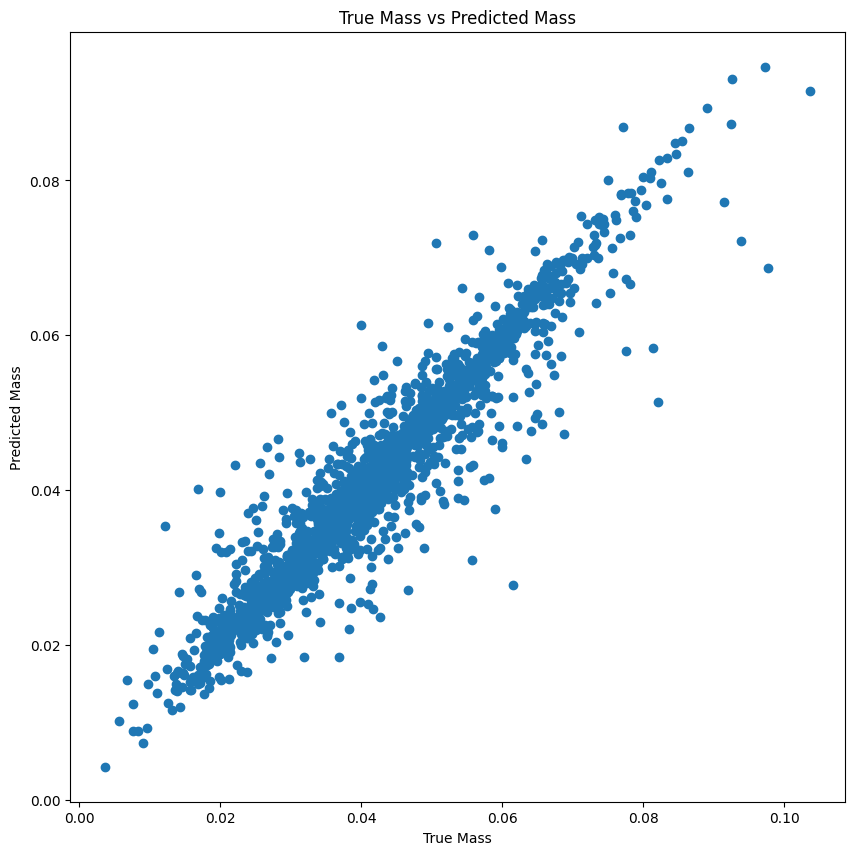

Test Loss: 0.000021


2.1368302758861638e-05

In [123]:
test(Resnet18, test_loader, nn.MSELoss())

100%|██████████| 63/63 [00:15<00:00,  3.97it/s]


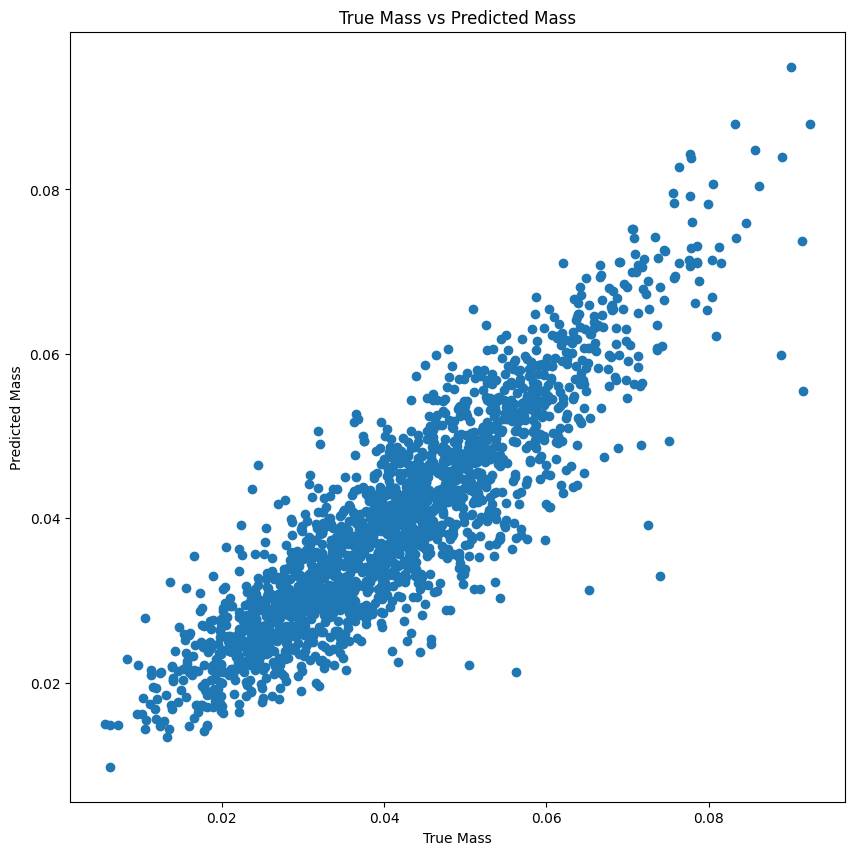

Test Loss: 0.000048


4.7850316164724986e-05

In [126]:
test(EffNet, test_loader, nn.MSELoss())